In [341]:
from matplotlib.colors import to_rgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os

class MetricsAnalyzer:
    def __init__(self, halstead_path, loc_path, cc_path):
        self.halstead_path = halstead_path
        self.loc_path = loc_path
        self.cc_path = cc_path
        self.df_master = self._build_master_dataframe()
        self.color_map = self._build_color_map()

    def _clean_algorithm_name(self, name):
        return re.sub(r"^\d{2}[-_]", "", name)

    def _build_color_map(self, palette_name="Set3"):
        palette = sns.color_palette(palette_name, n_colors=10)
        palette[1] = to_rgb("#FFFF4B")   
        languages = ["cirq", "quapl", "qiskit", "qrisp", "qmod", "q#", "qasm", "classic"]
        return {lang: palette[i % len(palette)] for i, lang in enumerate(languages)}

    def _build_master_dataframe(self):
        halstead_df = pd.read_csv(self.halstead_path, index_col=0)
        loc_df = pd.read_csv(self.loc_path, index_col=0)
        cc_df = pd.read_csv(self.cc_path, index_col=0)
        halstead_df.rename(columns={"Directory": "Language"}, inplace=True)
        loc_melted = loc_df.reset_index().melt(id_vars="index", var_name="Algorithm", value_name="LOC")
        loc_melted.rename(columns={"index": "Language"}, inplace=True)
        cc_melted = cc_df.reset_index().melt(id_vars="index", var_name="Algorithm", value_name="CC")
        cc_melted.rename(columns={"index": "Language"}, inplace=True)
        loc_melted["Algorithm"] = loc_melted["Algorithm"].apply(self._clean_algorithm_name)
        cc_melted["Algorithm"] = cc_melted["Algorithm"].apply(self._clean_algorithm_name)
        metrics_df = pd.merge(loc_melted, cc_melted, on=["Algorithm", "Language"], how="outer")
        halstead_df["Algorithm"] = halstead_df["File Name"].apply(
            lambda x: self._clean_algorithm_name(re.sub(r".*?/", "", x).replace(".py", "")))
        halstead_metrics = halstead_df[
            ["Algorithm", "Language", "Vocabulary", "Length", "Volume", "Difficulty", "Effort"]
        ]
        master_df = pd.merge(metrics_df, halstead_metrics, on=["Algorithm", "Language"], how="left")
        return master_df

    def filter_data(self, language_type="all"):
        lang_map = {
            "hosted": ["cirq", "quapl", "qiskit", "qrisp"],
            "standalone": ["q#", "qmod"],
            "all": ["cirq", "quapl", "qiskit", "qrisp", "q#", "qmod"]
        }
        return self.df_master[self.df_master["Language"].isin(lang_map[language_type])].copy()

    def plot_metric_by(self, df, metric="LOC", by="Algorithm", agg="mean", attributes: dict=None):
        algorithm_order = ["deutsch-jotza","bernstein-vazirani","simon","grover"]
        if by == "Language":
            df_plot = df.groupby("Language")[metric].agg(agg).reset_index()
        else:
            df_plot = df.groupby([by, "Language"])[metric].agg(agg).reset_index()     

        if by == "Algorithm":
            df_plot[by] = pd.Categorical(df_plot[by], categories=algorithm_order, ordered=True)
       
        df_plot = df_plot.sort_values(by=metric, ascending=True)
        plt.figure(figsize=(12, 6))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        sns.barplot(data=df_plot, x=by, y=metric, hue="Language", palette=self.color_map)
        plt.title(attributes.get("title", ""), fontsize=20)
        plt.xlabel(attributes.get("xlabel", "") , fontsize=16)
        plt.ylabel(attributes.get("ylabel", ""), fontsize=16)
        plt.xticks(rotation=45, fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(title="Programming Language", loc="upper left", fontsize=10, title_fontsize=11)

        plt.tight_layout()
        title = attributes.get('title', "title")
        self.save_plot("results/graphics/"+title+".png")
        plt.show()
    
    def plot_average_metric_by_language(self, df, metric="LOC", agg="mean", attributes: dict = None):
        if attributes is None:
            attributes = {}
        df_plot = df.groupby("Language")[metric].agg(agg).reset_index()
        df_plot = df_plot.sort_values(by=metric, ascending=True)
        plt.figure(figsize=(12, 6))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)
        plt.title(attributes.get("title", f"Average {metric} per Language"), fontsize=20)
        plt.xlabel(attributes.get("xlabel", "Programming Language"), fontsize=16)
        plt.ylabel(attributes.get("ylabel", f"Average {metric}"), fontsize=16)
        plt.xticks(rotation=45, fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()
        title = attributes.get('title', "title")
        self.save_plot("results/graphics/"+title+".png")
        plt.show()

    def plot_loc_vs_cc(self, df, agg="mean", title="Lines of Code vs Cyclomatic Complexity"):
        df_plot = df.groupby("Language")[["LOC", "CC"]].agg(agg).reset_index()
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df_plot, x="LOC", y="CC", hue="Language", palette=self.color_map, s=100)
        for i in range(df_plot.shape[0]):
            plt.text(df_plot["LOC"][i]+0.3, df_plot["CC"][i], df_plot["Language"][i])        
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(title)
        plt.tight_layout()
        self.save_plot("results/graphics/"+title+".png")
        plt.show()

    def mean_data(self, df):
        columns_metrics = [
            "n1 (Unique Operators)", "n2 (Unique Operands)", 
            "N1 (Total Operators)", "N2 (Total Operands)", 
            "Vocabulary", "Length", "Volume", "Difficulty", "Effort"
        ]
        df_average = df.groupby("Directory")[columns_metrics].mean().round(2).reset_index()
        return df_average


    def plot_radar_chart(self, df, attributes):
        halstead_metrics = ["Vocabulary", "Length", "Volume", "Difficulty", "Effort", "LOC", "CC"]
        df_grouped = df.groupby("Language")[halstead_metrics].mean()
        df_normalized = self.normalize_metrics(df_grouped, columns=halstead_metrics)        
        df_normalized = df_normalized.select_dtypes(include=[np.number])
        labels = df_normalized.columns.tolist()
        num_vars = len(labels)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        for idx, row in df_normalized.iterrows():
            values = row.tolist()
            values += values[:1]
            color = self.color_map.get(idx, "gray")
            ax.plot(angles, values, label=idx, linewidth=2, color=color)            
            ax.fill(angles, values, alpha=0.1, color=color)
        ax.set_title(attributes.get("title", ""), size=15, y=1.1)
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        ax.set_ylim(0, 1)
        ax.legend( title="Programming Language", loc='upper right', bbox_to_anchor=(1.2, 1.1))
        plt.tight_layout()
        title = attributes.get('title', "title")
        self.save_plot("results/graphics/"+title+".png")
        plt.show()
        
    def normalize_metrics(self, df, columns):
        return ((df[columns] - df[columns].mean()) / df[columns].std()).add(5).div(10)
    
    def metrics_pairs(self):
        return [
            ("LOC", "CC"),
            ("LOC", "Effort"),
            ("CC", "Effort"),
            ("Volume", "Effort"),
            ("Difficulty", "Effort"),
            ("LOC", "Vocabulary")
        ]
    
    def metrics_pairs_all(self):
        return [
            ("LOC", "CC"),
            ("LOC", "Effort"),
            ("CC", "Effort"),
            ("Volume", "Effort"),
            ("Difficulty", "Effort"),
            ("LOC", "Vocabulary"),
            ("LOC", "Length"),
            ("LOC", "Volume"),
            ("LOC", "Difficulty"),            
            ("CC", "Vocabulary"),
            ("CC", "Length"),
            ("CC", "Volume"),
            ("CC", "Difficulty"),            
            ("Vocabulary", "Length"),
            ("Vocabulary", "Volume"),
            ("Vocabulary", "Difficulty"),
            ("Vocabulary", "Effort"),
            ("Length", "Volume"),
            ("Length", "Difficulty"),
            ("Length", "Effort"),
            ("Volume", "Difficulty")
        ]
    
    def plot_scatter_grid_metrics(self, df, attributes=None):
        if attributes is None:
            attributes = {}
        df_grouped = df.groupby("Language")[
            ["LOC", "CC", "Vocabulary", "Length", "Volume", "Difficulty", "Effort"]
        ].mean().reset_index()
        df_grouped = df_grouped[~df_grouped["Language"].isin(["qasm", "classic"])]        
        metric_pairs = self.metrics_pairs()
        cols = 3
        rows = (len(metric_pairs) + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(18, 5 * rows))
        axs = axs.flatten()
        for i, (x, y) in enumerate(metric_pairs):
            ax = axs[i]
            sns.scatterplot(data=df_grouped, x=x, y=y, hue="Language", s=100, ax=ax, palette=self.color_map)
            for j in range(df_grouped.shape[0]):
                ax.text(df_grouped[x].iloc[j] + 0.5, df_grouped[y].iloc[j], df_grouped["Language"].iloc[j], fontsize=9)
            ax.set_title(f"{x} vs {y}", fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.6)
        # Remove any empty subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        plt.tight_layout()
        save_path = "results/graphics/10_scatter_matrix_metrics.png"
        self.save_plot(save_path)
        plt.show()   

    def plot_scatter_grid_language_clouds(self, df, attributes=None):
        if attributes is None:
            attributes = {}
        df_filtered = df[~df["Language"].isin(["qasm", "classic"])]
        metric_pairs = self.metrics_pairs_all()
        cols = 1
        rows = (len(metric_pairs) + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(18, 5 * rows))
        axs = axs.flatten()
        for i, (x, y) in enumerate(metric_pairs):
            ax = axs[i]
            sns.scatterplot(
                data=df_filtered,
                x=x,
                y=y,
                hue="Language",
                style="Algorithm",
                s=100,
                ax=ax,
                palette='Set2',
            )
            for j in range(df_filtered.shape[0]):
                ax.text(
                    df_filtered[x].iloc[j] + 0.5,
                    df_filtered[y].iloc[j],
                    df_filtered["Algorithm"].iloc[j],
                    fontsize=8,
                    alpha=0.7
                )
            ax.set_title(f"{x} vs {y}", fontsize=14)
            ax.grid(True, linestyle='--', alpha=0.6)
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()
        save_path = "results/graphics/12_scatter_cloud_by_language.png"
        self.save_plot(save_path)
        plt.show()


    def save_plot(self, save_path):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Plot saved at: {save_path}")

    def run(self, language_type="all", chart_type=["loc_by_algorithm"], attributes=None):
        if isinstance(chart_type, str):
            chart_type = [chart_type]
        if attributes is None:
            attributes = {}
        df = self.filter_data(language_type)
        for chart in chart_type:
            if chart == "loc_by_algorithm":
                self.plot_metric_by(df, metric="LOC", by="Algorithm", attributes=attributes)
            elif chart == "cc_by_algorithm":
                self.plot_metric_by(df, metric="CC", by="Algorithm", attributes=attributes)
            elif chart == "loc_avg_by_algorithm":
                self.plot_average_metric_by_language(df, metric="LOC", attributes=attributes)
            elif chart == "cc_avg_by_algorithm":
                self.plot_average_metric_by_language(df, metric="CC", attributes=attributes)
            elif chart == "loc_by_language":
                self.plot_metric_by(df, metric="LOC", by="Language", attributes=attributes)
            elif chart == "cc_by_language":
                self.plot_metric_by(df, metric="CC", by="Language", attributes=attributes)
            elif chart == "loc_vs_cc":
                self.plot_loc_vs_cc(df, title=attributes.get("title", ""))
            elif chart == "radar":
                self.plot_radar_chart(df, attributes=attributes)
            elif chart == "scatter_matrix":
                self.plot_scatter_grid_metrics(df)
            elif chart == "scatter_matrix_algorithm":
                self.plot_scatter_grid_language_clouds(df)



In [342]:
analyzer = MetricsAnalyzer(
    halstead_path="results/halstead.csv",
    loc_path="results/loc.csv",
    cc_path="results/cyclomatic_complexity_calculator.csv"
)

df = analyzer._build_master_dataframe()
halstead_df = pd.read_csv("results/halstead.csv", index_col=0)
analyzer.mean_data(halstead_df)
#analyzer.run(language_type="hosted", chart_type=["loc_by_algorithm", "loc_vs_cc"])


,Directory,n1 (Unique Operators),n2 (Unique Operands),N1 (Total Operators),N2 (Total Operands),Vocabulary,Length,Volume,Difficulty,Effort
0,cirq,23.75,13.25,117.00,61.50,37.00,178.50,938.61,55.21,59390.94
1,classic,5.00,27.50,17.00,73.00,32.50,90.00,456.29,6.35,2803.52
2,q#,28.25,13.75,86.50,52.75,42.00,139.25,758.65,55.43,47715.10
3,qasm,5.75,7.00,39.00,28.25,12.75,67.25,264.05,15.59,3717.16
4,qiskit,19.75,13.50,50.25,60.25,33.25,110.50,569.56,44.23,29898.75
5,qmod,13.00,8.75,27.00,32.75,21.75,59.75,264.66,24.76,6629.53
6,qrisp,18.75,10.50,45.75,50.00,29.25,95.75,475.02,47.98,28814.38
7,quapl,29.75,17.75,115.75,62.25,47.50,178.00,1001.72,47.85,57809.82


In [343]:
analyzer.df_master

,Language,Algorithm,LOC,CC,Vocabulary,Length,Volume,Difficulty,Effort
0,cirq,bernstein-vazirani,17.0,7.0,34.0,112.0,569.795838,43.200000,24615.180211
1,classic,bernstein-vazirani,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,q#,bernstein-vazirani,27.0,7.0,39.0,104.0,549.681831,39.285714,21594.643351
3,qasm,bernstein-vazirani,17.0,1.0,8.0,51.0,153.000000,15.833333,2422.500000
4,qiskit,bernstein-vazirani,15.0,5.0,24.0,58.0,265.927825,32.000000,8509.690401
5,qmod,bernstein-vazirani,25.0,8.0,30.0,62.0,304.227217,36.166667,11002.884346
6,qrisp,bernstein-vazirani,15.0,5.0,23.0,57.0,257.843031,35.428571,9135.010259
7,quapl,bernstein-vazirani,11.0,10.0,48.0,109.0,608.760913,38.681818,23547.978937
8,cirq,deutsch-jotza,24.0,21.0,34.0,162.0,824.168980,40.000000,32966.759211
9,classic,deutsch-jotza,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot saved at: results/graphics/Lines of Code by Algorithm in Quantum Programming Languages.png


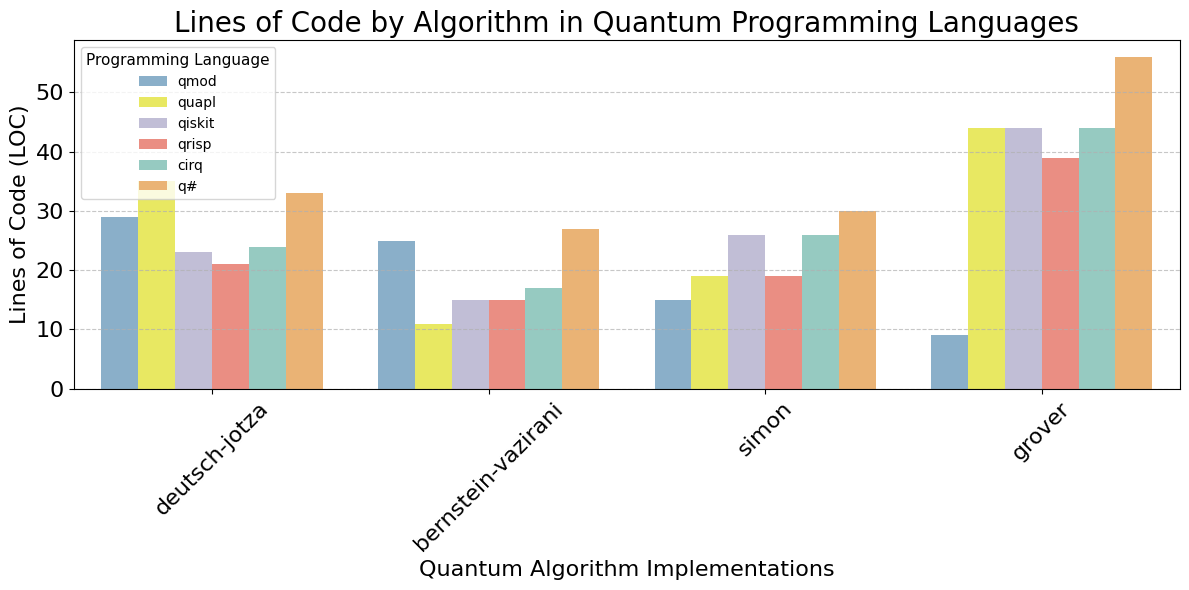

Plot saved at: results/graphics/Cyclomatic Complexity by Algorithm in Quantum Programming Languages.png


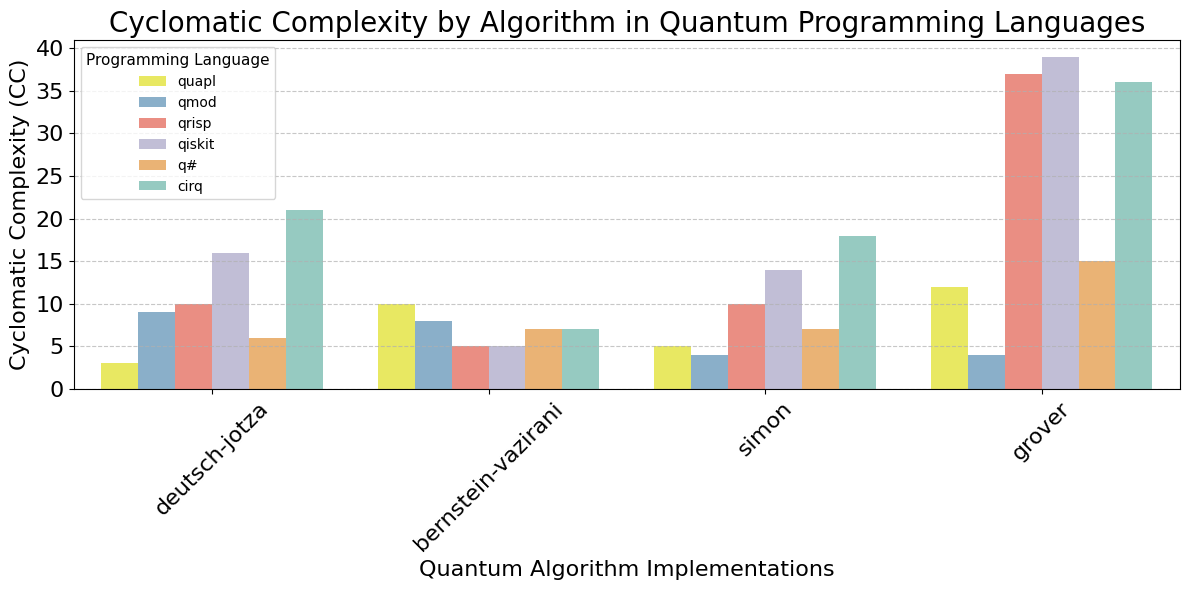

Plot saved at: results/graphics/Average Lines of Code by Algorithm Across Quantum Programming Languages.png


C:\Users\franc\AppData\Local\Temp\ipykernel_27068\367947625.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


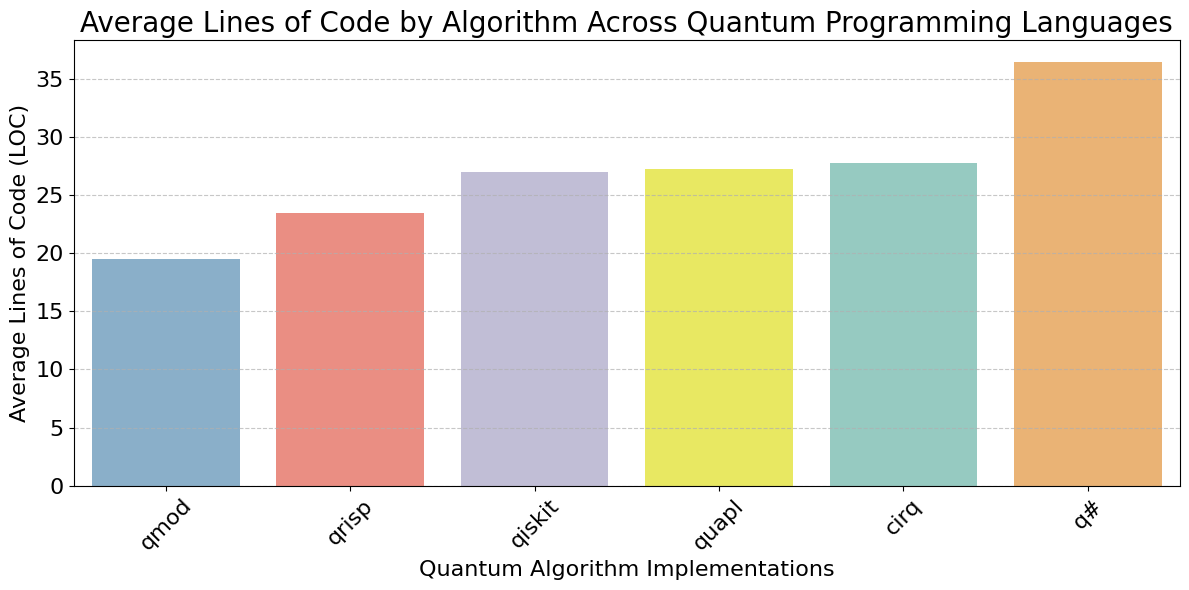

C:\Users\franc\AppData\Local\Temp\ipykernel_27068\367947625.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


Plot saved at: results/graphics/Average Cyclomatic Complexity by Algorithm Across Quantum Programming Languages.png


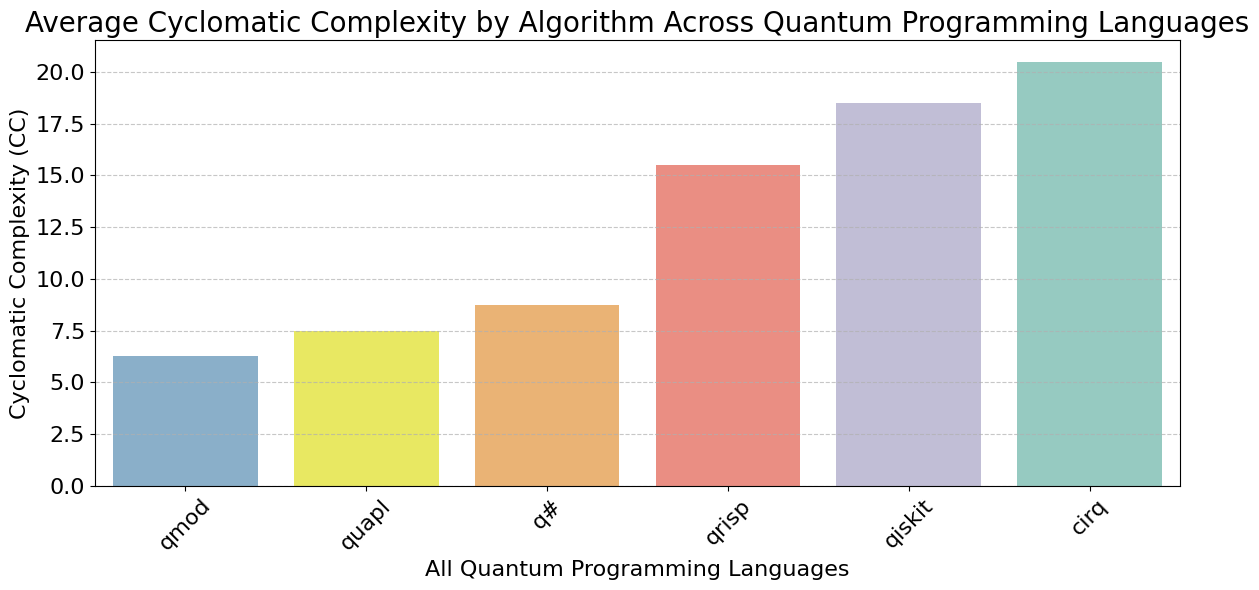

Plot saved at: results/graphics/Lines of Code by Algorithm Across Hosted Quantum Programming Languages.png


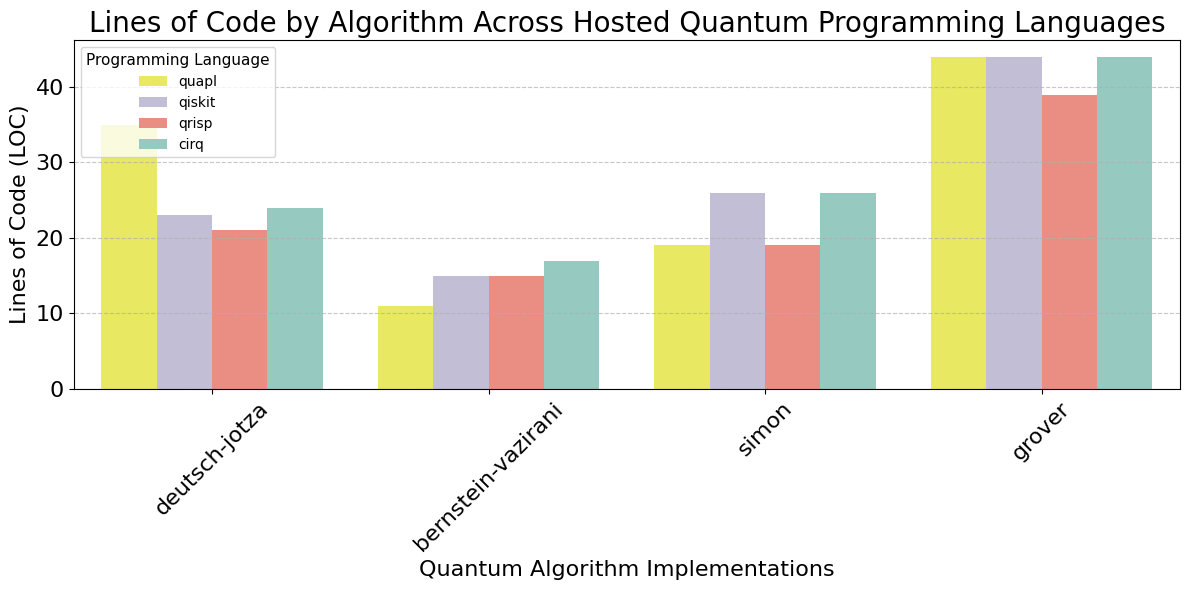

Plot saved at: results/graphics/Lines of Code by Algorithm Across Standalone Quantum Programming Languages.png


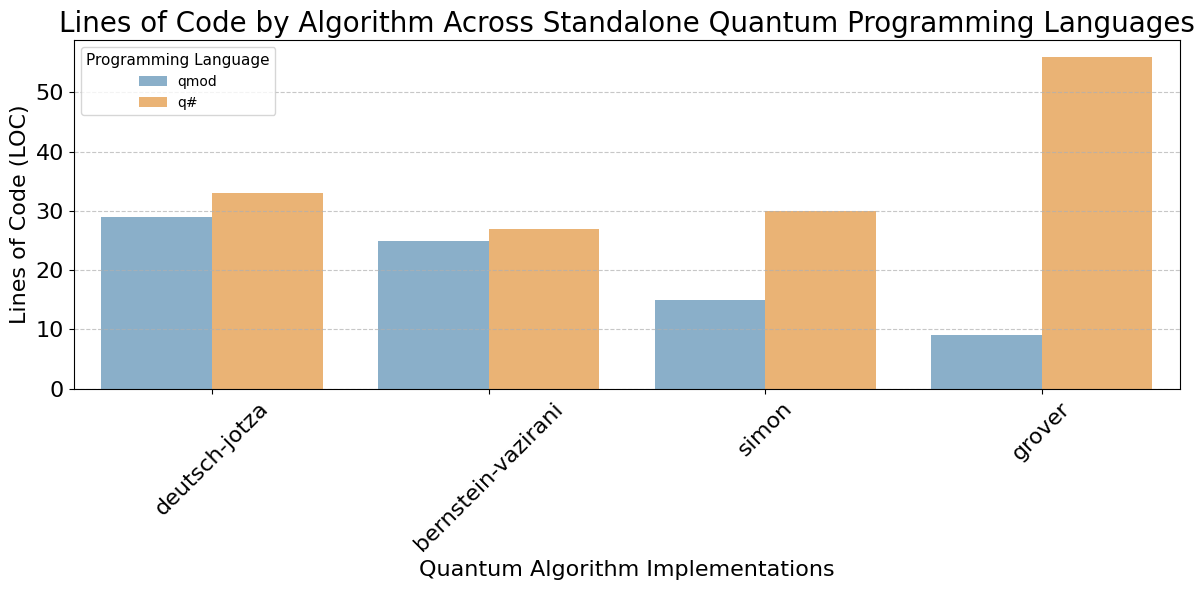

Plot saved at: results/graphics/Cyclomatic Complexity by Algorithm Across Hosted Quantum Programming Languages.png


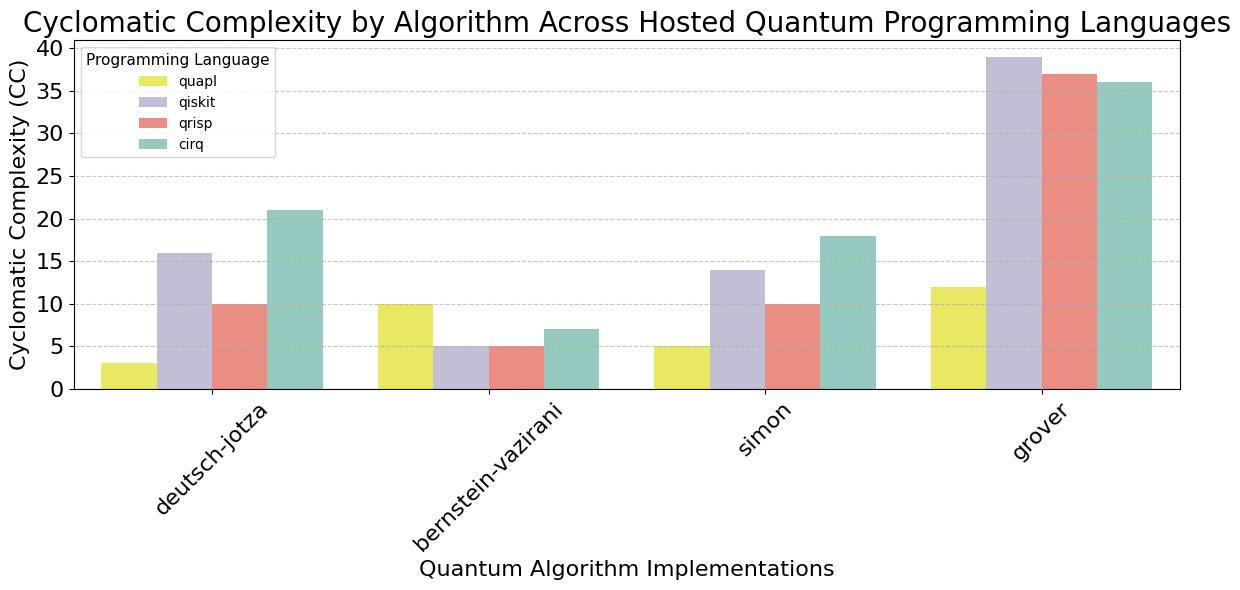

Plot saved at: results/graphics/Cyclomatic Complexity by Algorithm Across Standalone Quantum Programming Languages.png


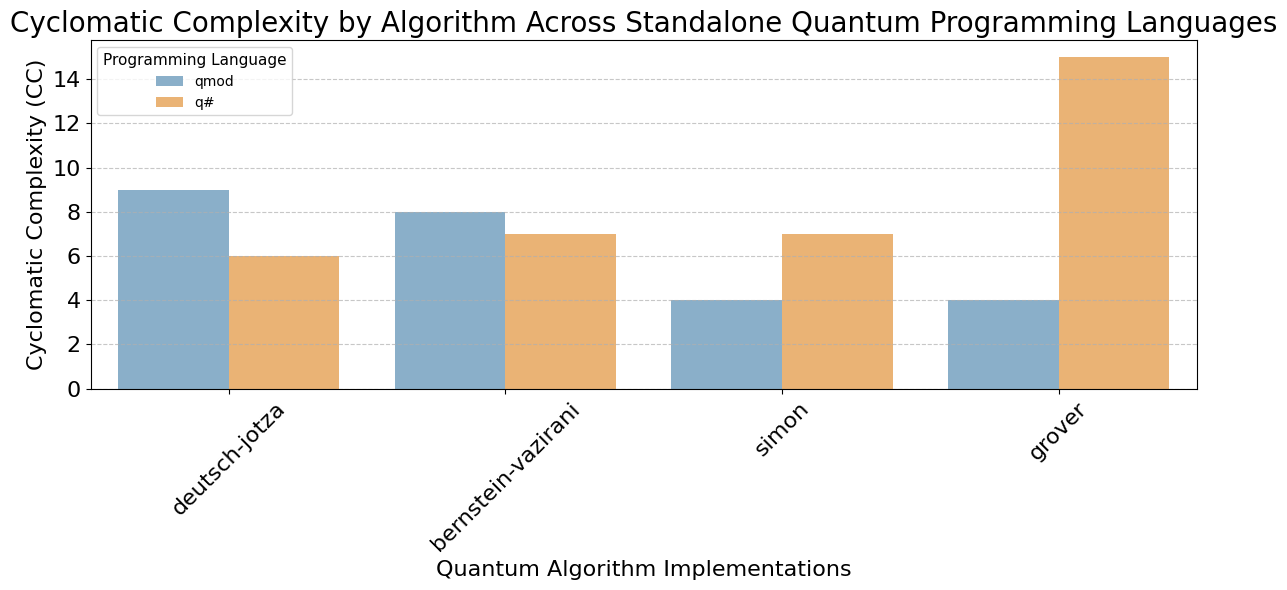

Plot saved at: results/graphics/Average Lines of Code by Algorithm Across Hosted Quantum Programming Languages.png


C:\Users\franc\AppData\Local\Temp\ipykernel_27068\367947625.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


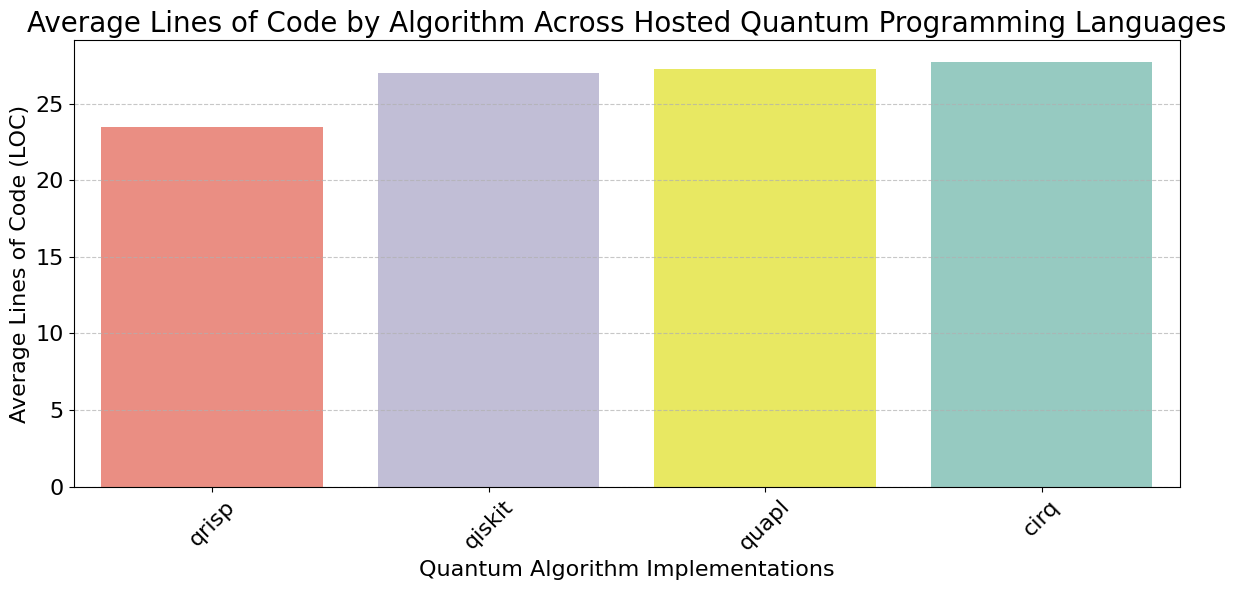

C:\Users\franc\AppData\Local\Temp\ipykernel_27068\367947625.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


Plot saved at: results/graphics/Average Lines of Code by Algorithm Across Standalone Quantum Programming Languages.png


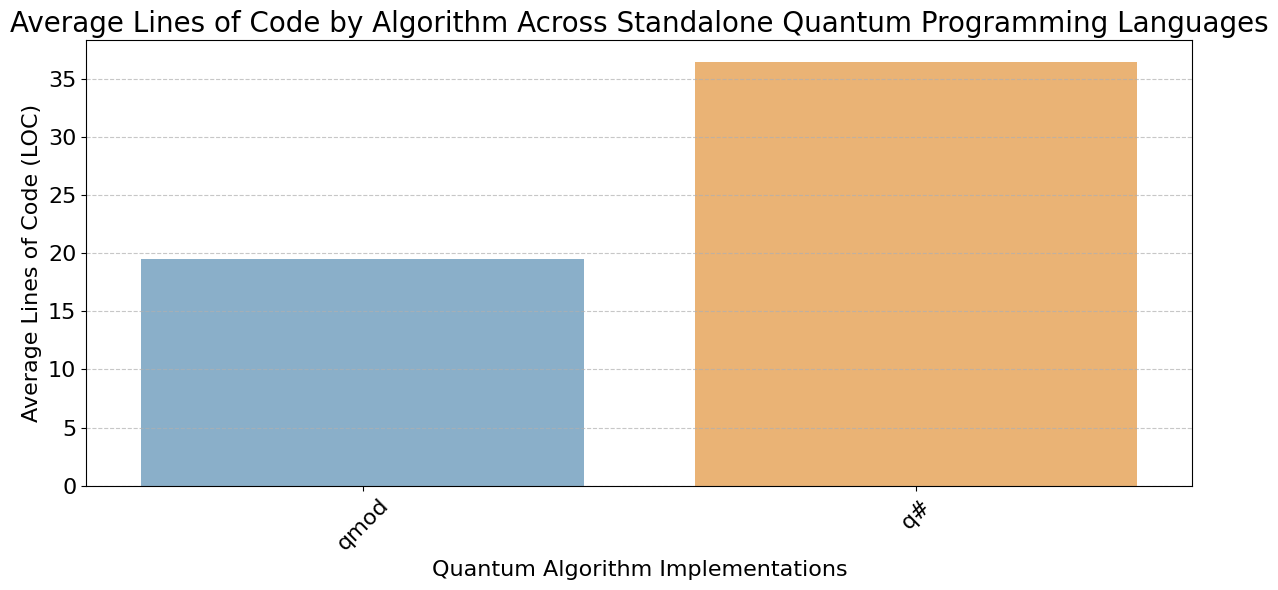

C:\Users\franc\AppData\Local\Temp\ipykernel_27068\367947625.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


Plot saved at: results/graphics/Average Cyclomatic Complexity by Algorithm Across Hosted Quantum Programming Languages.png


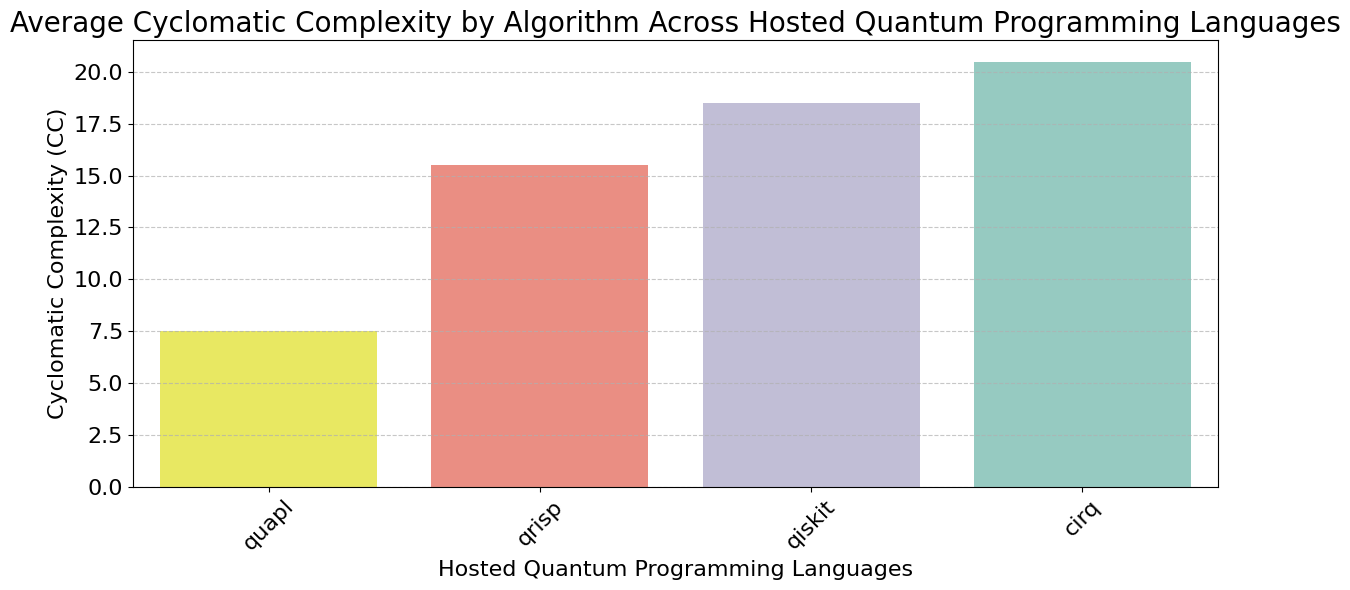

Plot saved at: results/graphics/Average Cyclomatic Complexity by Algorithm Across Standalone Quantum Programming Languages.png


C:\Users\franc\AppData\Local\Temp\ipykernel_27068\367947625.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Language", y=metric, palette=self.color_map)


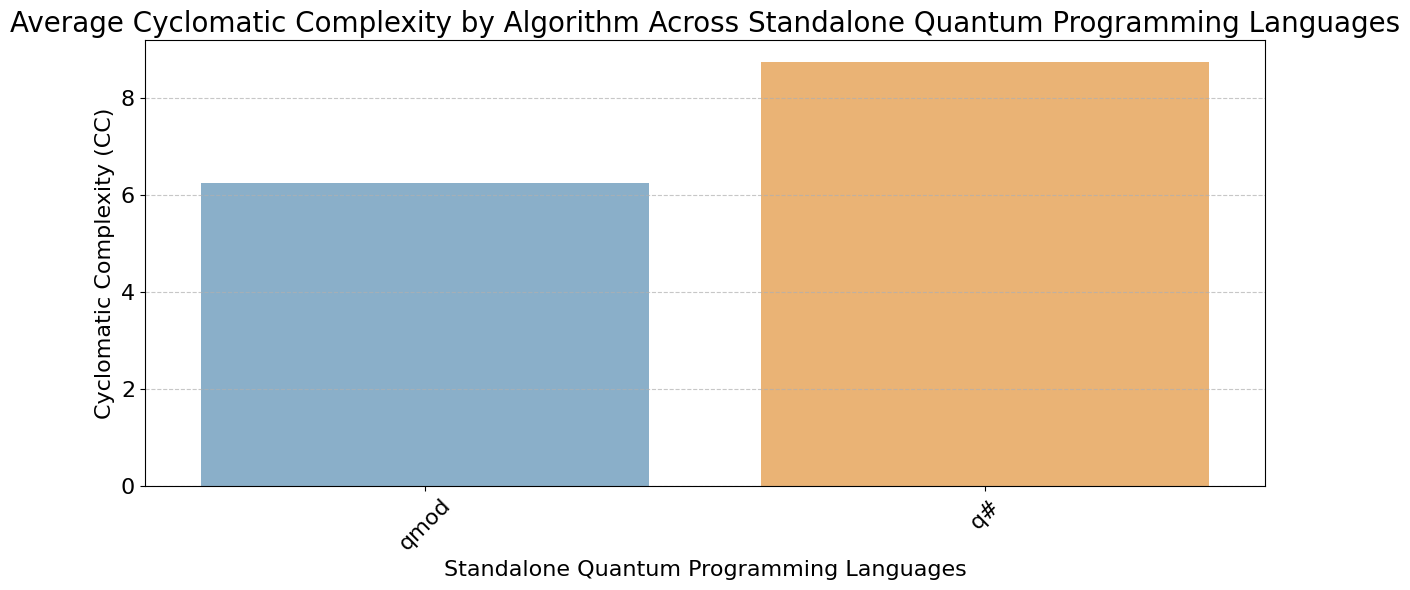

In [344]:
# LOC y CC por algoritmo (todos los lenguajes)
analyzer.run(language_type="all", chart_type=["loc_by_algorithm"], attributes={
    'title': 'Lines of Code by Algorithm in Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Lines of Code (LOC)',
})

analyzer.run(language_type="all", chart_type=["cc_by_algorithm"], attributes={
    'title': 'Cyclomatic Complexity by Algorithm in Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Cyclomatic Complexity (CC)',
})


analyzer.run(language_type="all", chart_type=["loc_avg_by_algorithm"], attributes={
    'title': 'Average Lines of Code by Algorithm Across Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Average Lines of Code (LOC)',
})

analyzer.run(language_type="all", chart_type=["cc_avg_by_algorithm"], attributes={
    'title': 'Average Cyclomatic Complexity by Algorithm Across Quantum Programming Languages',
    'xlabel': 'All Quantum Programming Languages',
    'ylabel': 'Cyclomatic Complexity (CC)',
})

# LOC por algoritmo - Hosted y Standalone
analyzer.run(language_type="hosted", chart_type=["loc_by_algorithm"], attributes={
    'title': 'Lines of Code by Algorithm Across Hosted Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Lines of Code (LOC)',
})

analyzer.run(language_type="standalone", chart_type=["loc_by_algorithm"], attributes={
    'title': 'Lines of Code by Algorithm Across Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Lines of Code (LOC)',
})

# CC por algoritmo - Hosted y Standalone
analyzer.run(language_type="hosted", chart_type=["cc_by_algorithm"], attributes={
    'title': 'Cyclomatic Complexity by Algorithm Across Hosted Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Cyclomatic Complexity (CC)',
})

analyzer.run(language_type="standalone", chart_type=["cc_by_algorithm"], attributes={
    'title': 'Cyclomatic Complexity by Algorithm Across Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Cyclomatic Complexity (CC)',
})

analyzer.run(language_type="hosted", chart_type=["loc_avg_by_algorithm"], attributes={
    'title': 'Average Lines of Code by Algorithm Across Hosted Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Average Lines of Code (LOC)',
})

analyzer.run(language_type="standalone", chart_type=["loc_avg_by_algorithm"], attributes={
    'title': 'Average Lines of Code by Algorithm Across Standalone Quantum Programming Languages',
    'xlabel': 'Quantum Algorithm Implementations',
    'ylabel': 'Average Lines of Code (LOC)',
})

analyzer.run(language_type="hosted", chart_type=["cc_avg_by_algorithm"], attributes={
    'title': 'Average Cyclomatic Complexity by Algorithm Across Hosted Quantum Programming Languages',
    'xlabel': 'Hosted Quantum Programming Languages',
    'ylabel': 'Cyclomatic Complexity (CC)',
})

analyzer.run(language_type="standalone", chart_type=["cc_avg_by_algorithm"], attributes={
    'title': 'Average Cyclomatic Complexity by Algorithm Across Standalone Quantum Programming Languages',
    'xlabel': 'Standalone Quantum Programming Languages',
    'ylabel': 'Cyclomatic Complexity (CC)',
})



Plot saved at: results/graphics/Complexity Metrics for Hosted Quantum Programming Languages.png


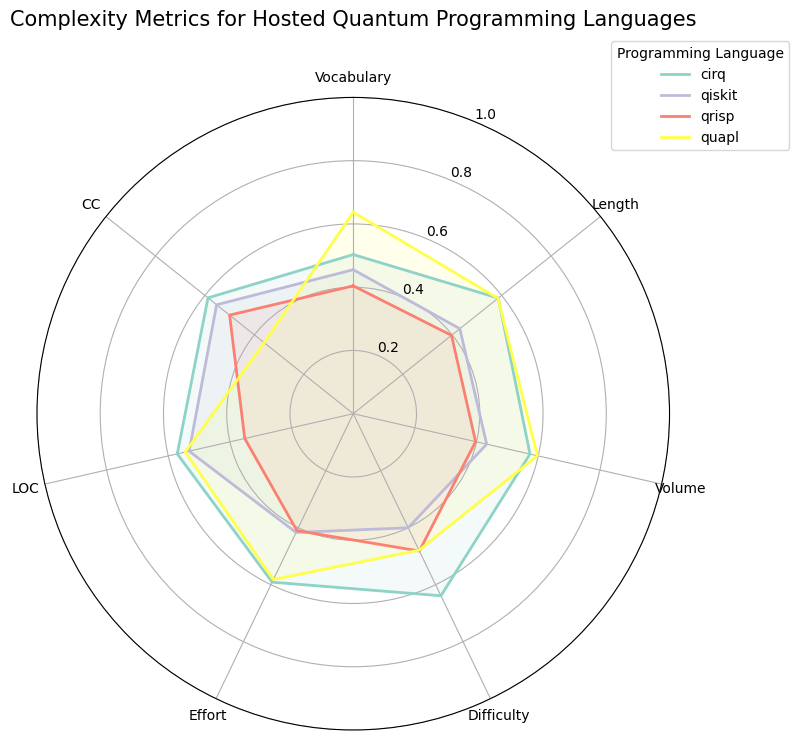

Plot saved at: results/graphics/Complexity Metrics for Standalone Quantum Programming Languages.png


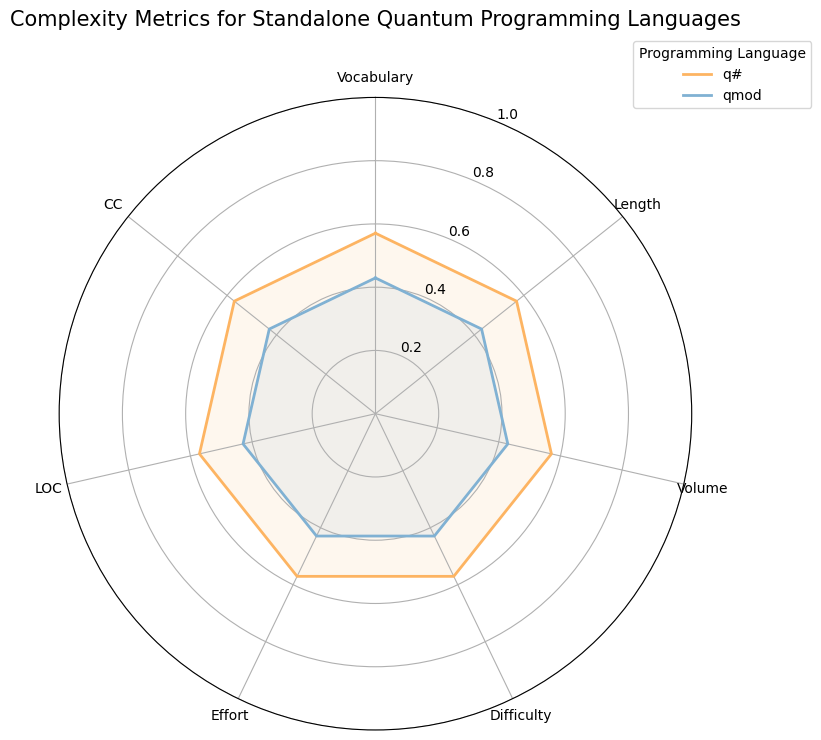

Plot saved at: results/graphics/Complexity Metrics for Quantum Programming Languages.png


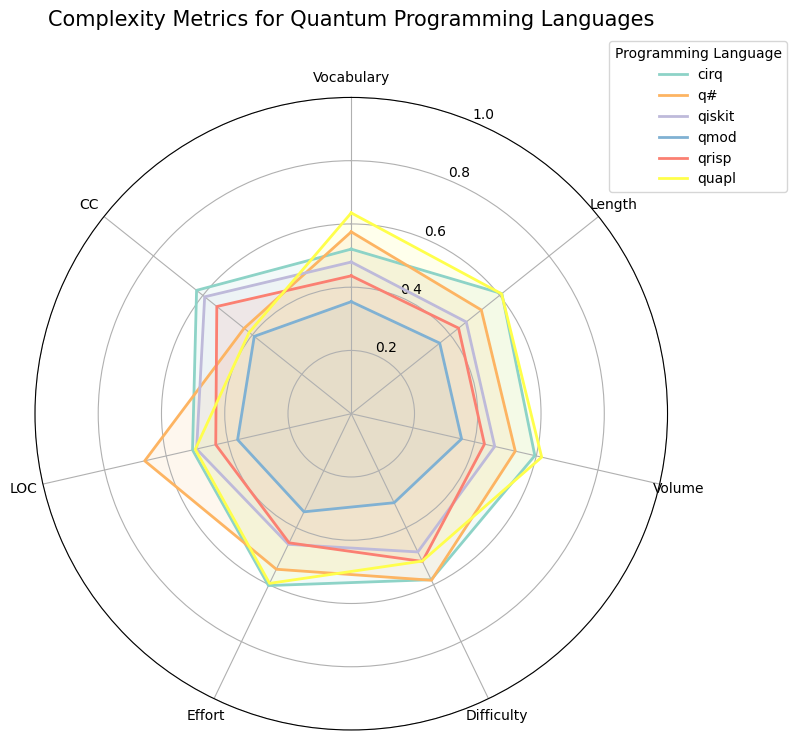

In [345]:
analyzer.run(language_type="hosted", chart_type=["radar"], attributes={'title': 'Complexity Metrics for Hosted Quantum Programming Languages'})
analyzer.run(language_type="standalone", chart_type=["radar"], attributes={'title': 'Complexity Metrics for Standalone Quantum Programming Languages'})
analyzer.run(language_type="all", chart_type=["radar"], attributes={'title': 'Complexity Metrics for Quantum Programming Languages'})

In [346]:
#analyzer.run(language_type="all", chart_type=["loc_vs_cc"], attributes={"title": "Lines of Code vs Cyclomatic Complexity Across Quantum Programming Languages"})

Plot saved at: results/graphics/10_scatter_matrix_metrics.png


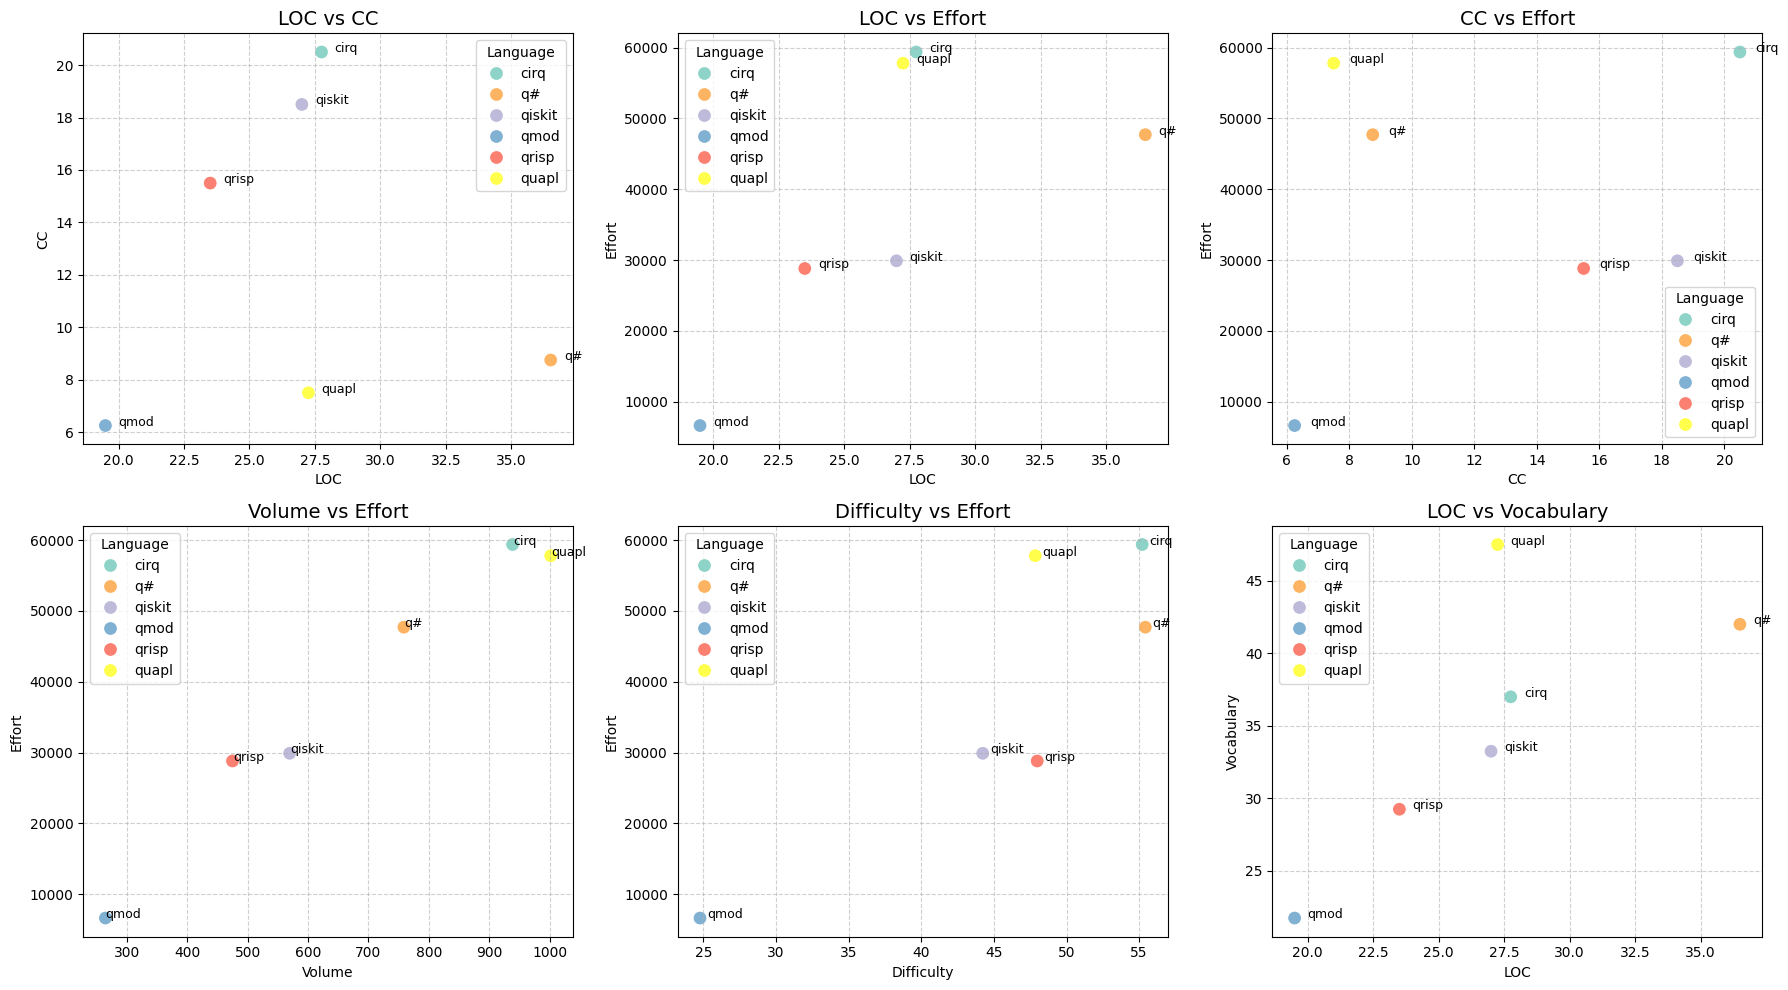

In [347]:
analyzer.run(language_type="all", chart_type="scatter_matrix")

Plot saved at: results/graphics/12_scatter_cloud_by_language.png


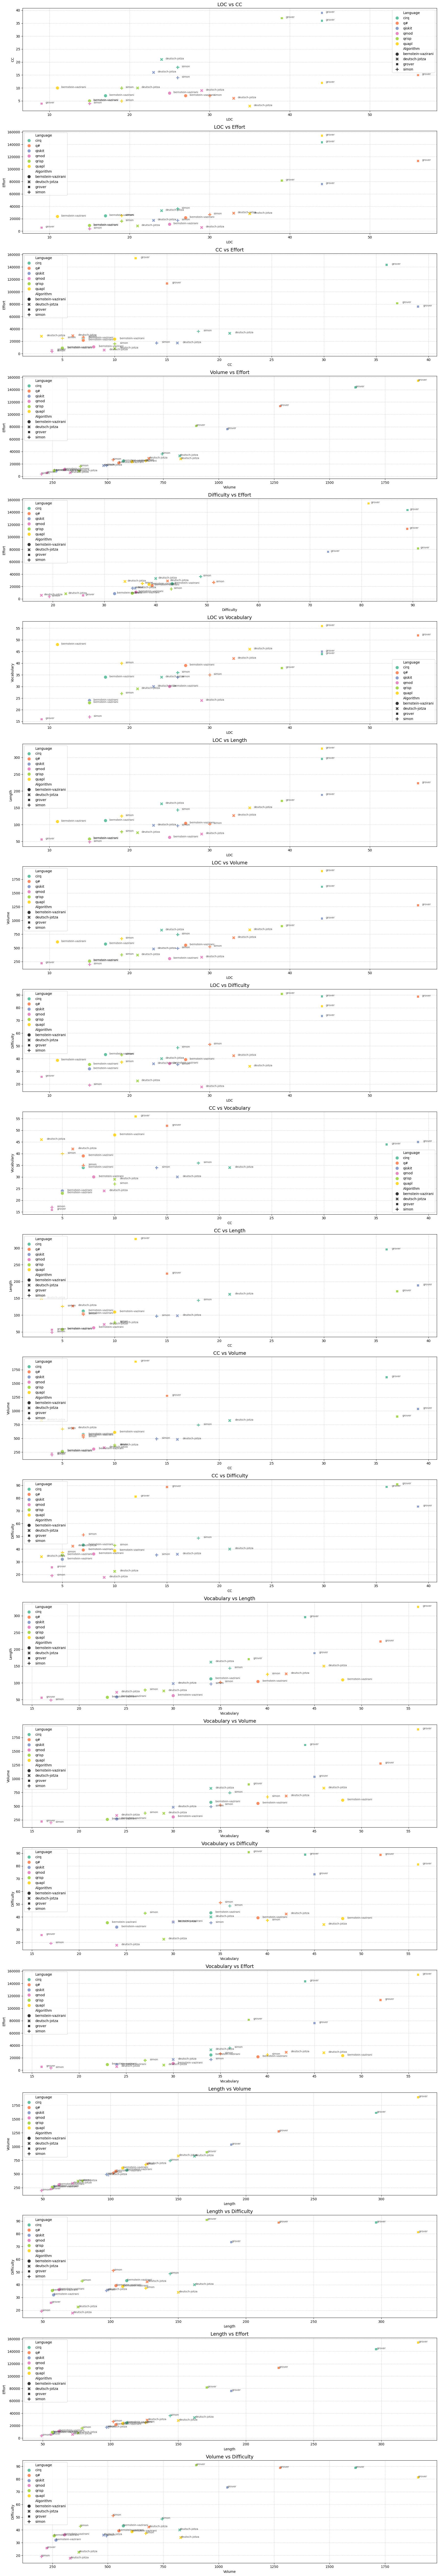

In [348]:
analyzer.run(language_type="all", chart_type="scatter_matrix_algorithm")

In [349]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Cargar los datos proporcionados
data = {
    "Language": ["cirq", "classic", "q#", "quapl", "qasm", "qiskit", "qmod", "qrisp"] * 4,
    "Algorithm": ["deutsch-jotza"] * 8 + ["grover"] * 8 + ["simon"] * 8 + ["bernstein-vazirani"] * 8,
    "LOC": [24,16,33,35,14,23,29,21,44,13,56,44,30,44,9,39,26,28,30,19,12,26,15,19,17,14,27,11,17,15,25,15],
    "CC": [21,11,6,3,1,16,9,10,36,5,15,12,1,39,4,37,18,14,7,5,1,14,4,10,7,9,7,10,1,5,8,5],
    "Vocabulary": [34,32,42,46,7,30,24,29,44,27,52,56,29,45,16,38,36,38,35,40,7,34,17,27,34,32,39,48,8,24,30,23],
    "Length": [162,75,127,150,42,98,72,76,296,65,224,327,142,189,56,171,144,115,102,126,34,97,49,79,112,75,104,109,51,58,62,57],
    "Volume": [824.168980,375.0,684.824313,828.534293,117.908907,480.875278,330.1173,369.206556,
               1615.991759,309.067688,1276.898497,1899.00506,689.833301,1037.960235,224.0,897.395605,
               744.4692,603.511664,523.186868,670.56294,95.450067,493.483896,200.285679,375.636113,
               569.795838,375.0,549.681831,608.760913,153.0,265.927825,304.227217,257.843031],
    "Difficulty": [40.0,3.362069,42.3,34.0,18.75,35.961538,17.769231,22.5,
                   88.933333,7.0,88.875,81.333333,12.761905,73.5,25.833333,91.0,
                   48.714286,5.705882,51.25,37.384615,15.0,35.466667,19.285714,43.0,
                   43.2,10.0,39.285714,38.681818,15.833333,32.0,36.166667,35.428571],
    "Effort": [32966.759211,1260.775862,28968.068427,28170.165976,2210.792001,17293.014818,5865.930486,8307.147502,
               143715.533777,2163.473813,113484.353909,154452.411507,8803.586893,76290.077288,5786.666667,81663.000037,
               36266.285324,3443.566554,26813.326971,25068.737601,1431.75101,17502.228831,3862.652385,16152.352845,
               24615.180211,3750.0,21594.643351,23547.978937,2422.5,8509.690401,11002.884346,9135.010259]
}

df = pd.DataFrame(data)

# Calcular correlaciones
pairs = [
    ("LOC", "Effort"),
    ("CC", "Effort"),
    ("Volume", "Effort"),
    ("LOC", "Length"),
    ("Vocabulary", "Difficulty")
]

results = []
for x, y in pairs:
    pearson_corr, _ = pearsonr(df[x], df[y])
    spearman_corr, _ = spearmanr(df[x], df[y])
    results.append({
        "Metric Pair": f"{x} vs {y}",
        "Pearson r": round(pearson_corr, 4),
        "Spearman ρ": round(spearman_corr, 4)
    })

results_df = pd.DataFrame(results)

#import ace_tools as tools; tools.display_dataframe_to_user(name="Correlaciones Métricas", dataframe=results_df)


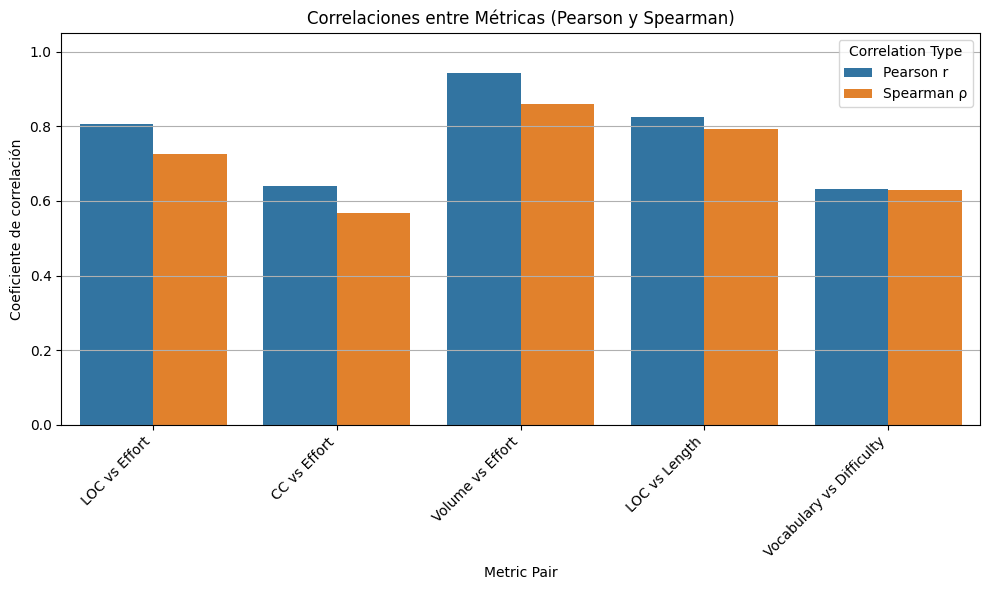

In [350]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un gráfico de barras comparando Pearson y Spearman
plt.figure(figsize=(10, 6))
results_df_melted = results_df.melt(id_vars="Metric Pair", var_name="Correlation Type", value_name="Correlation")

sns.barplot(data=results_df_melted, x="Metric Pair", y="Correlation", hue="Correlation Type")
plt.title("Correlaciones entre Métricas (Pearson y Spearman)")
plt.ylabel("Coeficiente de correlación")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.grid(axis="y")

plt.show()


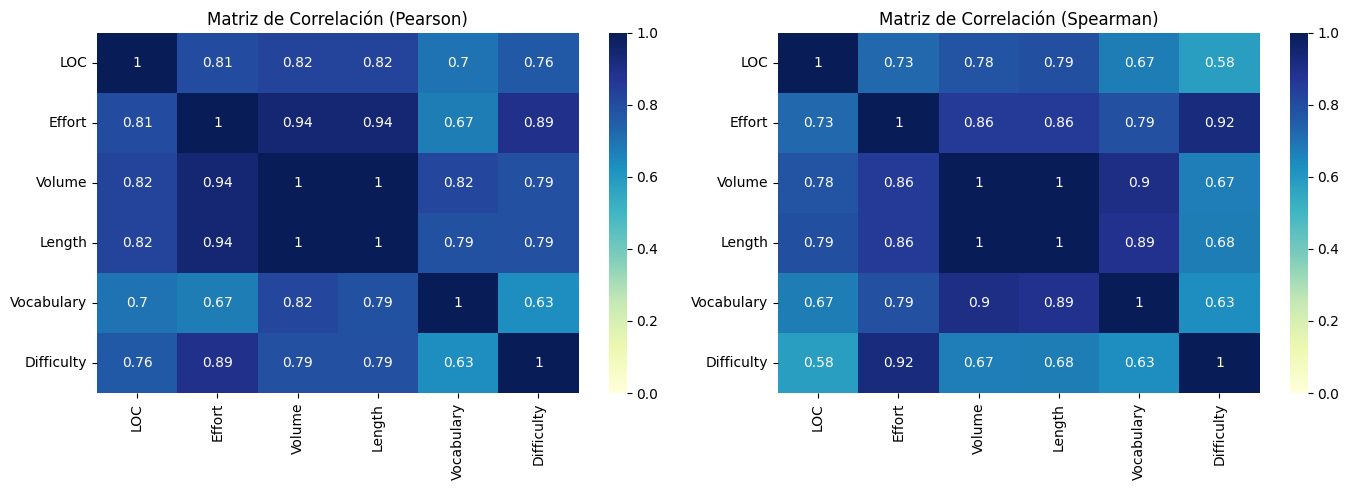

In [ ]:
# Seleccionamos solo las columnas numéricas relevantes
metrics = ["LOC", "Effort", "Volume", "Length", "Vocabulary", "Difficulty"]
numeric_df = df[metrics]

# Calculamos las matrices de correlación
pearson_corr_matrix = numeric_df.corr(method="pearson")
spearman_corr_matrix = numeric_df.corr(method="spearman")


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.heatmap(pearson_corr_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Matriz de Correlación (Pearson)")

plt.subplot(1, 2, 2)
sns.heatmap(spearman_corr_matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Matriz de Correlación (Spearman)")

plt.tight_layout()
plt.show()
